[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbsantiago/AI-Intervene-Training-Material/blob/main/BioacousticsAI/Notebook.ipynb)

# Week 6 AI & Bioacoustics

In this notebook you will explore computer audition applications in ecology, such as
automated animal detection and species classification from audio sensor data.

## Contents

1. [Introduction](#1-introduction)
2. [Setup](#2-setup)
3. [Detecting Animal Sounds](#3-detecting-animal-sounds)
4. [Identifying Sounds](#4-identifying-sounds)
5. [Conclusion](#5-conclusion)


## Notes

- If you see a line starting with 🖌️, it's asking you to check or tweak some code, or answer a question.
- Lines starting with the light bulb symbol (💡) provide important information or tips and tricks.
- Stop at each 🛑 symbol. We'll regroup and discuss the section before moving on.

---

## 1. Introduction

### 1.1 Computer Audition

Computer audition is the field of research that deals with the automatic analysis of audio signals.
It intersects with many other fields, including machine learning, signal processing, and computer
vision.

**What does a computer hear**?

- Audio files are a sequence of numbers representing the amplitude of the sound
  wave (pressure level) at a given time.

- The number of samples per second is called the **sampling rate**.

<img alt="audio and sampling rate" width="600"
src="https://cdn.shopify.com/s/files/1/1169/2482/files/Sampling_Rate_Cover_image.jpg?v=1654170259"></img>

**What tasks can we do with computer audition?**

Computer audition is used in a wide range of applications, including:

- Speech recognition: Siri, Alexa, Google Assistant
- Music information retrieval: Spotify, Shazam
- Audio classification: What is sounding in this audio?
- Sound event detection: Transcription of audio into a sequence of events.

<img alt="Sound event detection" width="400"
src="http://d33wubrfki0l68.cloudfront.net/508a62f305652e6d9af853c65ab33ae9900ff38e/17a88/images/tasks/challenge2016/task3_overview.png"></img>

> Taken from the paper: Mesaros, A., Heittola, T., Diment, A., Elizalde, B., Shah, A., Vincent, E.,
> ... & Virtanen, T. (2017, November). DCASE 2017 challenge setup: Tasks, datasets and baseline
> system. In DCASE 2017-Workshop on Detection and Classification of Acoustic Scenes and Events.

Recently, deep learning has taken over the field of computer audition and is being used to solve
many of the above tasks.

### 1.2 Data Collection

**Acoustic sensors** can be used to collect field recordings of animal sounds.

Usually, these sensors are deployed statically in the field for a long periods of time and record
sounds continuously. This is called **passive acoustic monitoring**.

<img alt="passive acoustic monitoring" width="400"
src="https://wittmann-tours.de/wp-content/uploads/2018/06/AudioMoth.jpg"></img>

Alternatively, recordings are actively directed towards a specific animal species or sound events.

<img alt="active recording" width="400"
src="https://s3.amazonaws.com/cdn.freshdesk.com/data/helpdesk/attachments/production/48032687175/original/xjI7Dy3Q9kaCZinr5vf4ksNxQbjK13Yv3A.jpg?1584552543"></img>

> Taken from the Macaulay Library blog post: [Sound recording
> tips](https://support.ebird.org/en/support/solutions/articles/48001064298-sound-recording-tips).

### 1.3 Acoustics for Ecology

The sound at a site is a reflection of the species present in the area and other
environmental factors.

<img alt="composition of acoustic space" width="500"
src="https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs12304-017-9288-5/MediaObjects/12304_2017_9288_Fig1_HTML.gif?as=webp"></img>

> Taken from the paper: Mullet, T.C., Farina, A. & Gage, S.H. The Acoustic
> Habitat Hypothesis: An Ecoacoustics Perspective on Species Habitat Selection.
> Biosemiotics 10, 319–336 (2017). https://doi.org/10.1007/s12304-017-9288-5

If we could link sounds to the species or individuals that produced them, we could use this information to
study and monitor the biodiversity of an area.

Acoustic sensors produce a lot of data, and it is not always easy to analyse.
Can we use computer audition to help us?

In this notebook we will explore the task of **animal sound detection** and **species
classification**, using both manual and automated methods.

---

## 2. Setup

### 2.1 Enable GPU Runtime

Go to `Runtime` -> `Change runtime type` and select `GPU` as the hardware accelerator.

### 2.2 Run the setup script

Please run the cell bellow to donwload the data you will be using in this notebook as well as to install the missing dependencies.

In [ ]:
! wget -q -O - https://raw.githubusercontent.com/jscanass/BIOS0032_AI4Environment/refs/heads/main/BioacousticsAI/setup.sh | bash

### 2.3 Import Dependencies

All the required dependencies for the notebook are in the cell below. Please run before anything else. If for any reason the runtime is restarted you will need to run it again.

In [ ]:
from pathlib import Path
from time import perf_counter

import audio_utils
import evaluation_utils
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotting_utils
import ipywidgets as widgets

import seaborn as sns
import tensorflow_hub as hub
from batdetect2 import api
from IPython.display import Audio, display
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from umap import UMAP

In [ ]:
from etils import epath
from ml_collections import config_dict

from perch_hoplite.agile import colab_utils
from perch_hoplite.agile import embed
from perch_hoplite.agile import ingest_annotations
from perch_hoplite.agile import source_info
from perch_hoplite.db import brutalism
from perch_hoplite.db import interface
from perch_hoplite.zoo import taxonomy_model_tf


from perch_hoplite.agile import audio_loader
from perch_hoplite.agile import classifier
from perch_hoplite.agile import classifier_data
from perch_hoplite.agile import embedding_display
from perch_hoplite.db import score_functions
from perch_hoplite.db  import search_results
from perch_hoplite.db import sqlite_usearch_impl
from perch_hoplite.zoo import model_configs

---

## 3: Detecting Animal Sounds

- Most of the time, we are not interested in all the sounds in a recording, but only in the sounds
  of a specific animal species.

- Acoustic sensors will indiscriminately record all sounds in the environment, including those of
  animals, wind, rain, _etc._ Although some recorders can be triggered by a specific sound, this is
  not always the case.

- Passive acoustic monitoring produces many hours of recordings, and it's hard to identify and
  explore the sounds of interest.

These are similar problems to the ones we have seen in the previous notebook for camera trap
images.

While not as developed as in **computer vision**, there are some tools for automatically **detecting
animal sounds** in recordings. Here we will explore a few of them.

But first we need to understand how to visualise and annotate sounds.

### 3.1 Animal Sounds Visualisation

- While we can listen to the sounds in a recording, it is often easier to visualise them.

- This is especially true when we want to compare sounds from different recordings or navigate
quickly without the need to listen.

- We can use waveplots and spectrograms to visualise the sounds in a recording.

Now we will load a dataset of animal recordings provided by
[Avisoft](https://www.avisoft.com/animal-sounds/) and visualise them.

In [41]:
DATA_DIR = Path.cwd() / "data"

In [42]:
AVISOFT_AUDIO_DIR = DATA_DIR / "avisoft" / "audio"
AVISOFT_METADATA_FILE = DATA_DIR / "avisoft" / "avisoft_metadata.csv"

In [43]:
# Load the metadata dataframe
avisoft = pd.read_csv(AVISOFT_METADATA_FILE)

In [44]:
# Print first few rows
avisoft.head()

english_name         scientific_name  \
0  Little Grebe  Tachybaptus ruficollis   
1  Little Grebe  Tachybaptus ruficollis   
2       Bittern      Botaurus stellaris   
3     Corncrake               Crex crex   
4     Corncrake               Crex crex   

                                           href      key   kingdom    phylum  \
0    https://www.avisoft.com/sounds/zwergta.wav  2482048  Animalia  Chordata   
1   https://www.avisoft.com/sounds/zwergta2.wav  2482048  Animalia  Chordata   
2   https://www.avisoft.com/sounds/rohrdomm.wav  2480910  Animalia  Chordata   
3   https://www.avisoft.com/sounds/corncrak.wav  4408498  Animalia  Chordata   
4  https://www.avisoft.com/sounds/corncrak2.wav  4408498  Animalia  Chordata   

              order         family        genus                 species class  \
0  Podicipediformes  Podicipedidae  Tachybaptus  Tachybaptus ruficollis  Aves   
1  Podicipediformes  Podicipedidae  Tachybaptus  Tachybaptus ruficollis  Aves   
2    Pelecaniformes       Ardeidae     Botaurus      Botaurus stellaris  Aves   
3        Gruiformes       Rallidae         Crex               Crex crex  Aves   
4        Gruiformes       Rallidae         Crex               Crex crex  Aves   

                            wav  
0    tachybaptus_ruficollis.wav  
1  tachybaptus_ruficollis_1.wav  
2        botaurus_stellaris.wav  
3                 crex_crex.wav  
4               crex_crex_1.wav

In [45]:
# select a random file from the dataset
random_recording = avisoft.sample(n=1).iloc[0]

# read the audio file and import it as a numpy array
wav, samplerate = librosa.load(AVISOFT_AUDIO_DIR / random_recording.wav, sr=None)

# Compute the duration of audio
num_samples = len(wav)  # Number of samples taken by the recorder
duration = num_samples / samplerate

# Get name of animal
animal_name = random_recording.english_name

print(f"File selected = {random_recording.wav}")
print(f"Samplerate = {samplerate} Hz")
print(f"Duration = {duration:.2f} s")
print(f"Species = {animal_name}")

File selected = sylvia_nisoria.wav
Samplerate = 11025 Hz
Duration = 2.56 s
Species = Barred Warbler


Let us first listen to the audio:

In [46]:
Audio(data=wav, rate=samplerate)

Text(0.5, 1.0, 'Waveform of Barred Warbler sound')

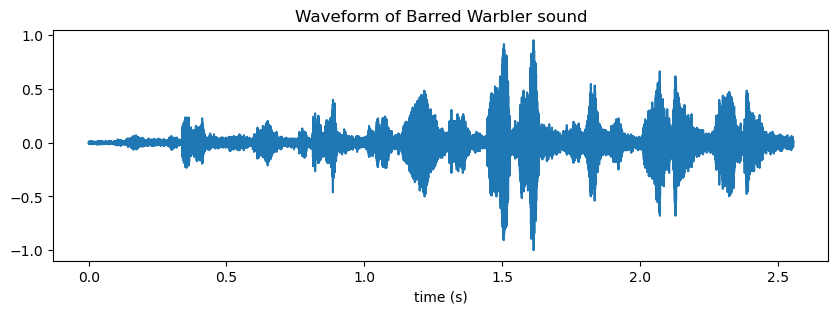

In [47]:
# Create plot of the waveform
times = np.linspace(0, duration, num_samples)
plt.figure(figsize=(10, 3))
plt.plot(times, wav)
plt.xlabel("time (s)")
plt.title(f"Waveform of {animal_name} sound")

The **waveform** gives us a visual representation of the sound amplitude over time.

However, if there are multiple simultaneous sounds in the recording, it can be hard to see each
individual sound.

We can use a **spectrogram** to decompose the sound into **frequencies** and visualise them as a 2D
image.

In [48]:
# Compute the spectrogram with the short time fourier transform (STFT)
spectrogram = np.abs(librosa.stft(wav))

# Amplitude is best represented in logarithmic scale (decibels)
db_spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)

Text(0, 0.5, 'freq (Hz)')

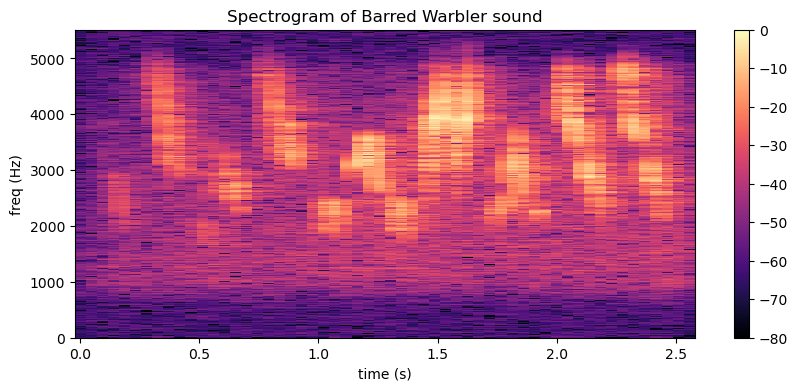

In [49]:
# Create plot of spectrogram
num_freq_bins, num_time_bins = db_spectrogram.shape
times = np.linspace(0, duration, num_time_bins)
freqs = np.linspace(0, samplerate / 2, num_freq_bins)

plt.figure(figsize=(10, 4))
plt.pcolormesh(times, freqs, db_spectrogram, cmap="magma")
plt.colorbar()
plt.title(f"Spectrogram of {random_recording.english_name} sound")
plt.xlabel("time (s)")
plt.ylabel("freq (Hz)")

The sounds produced by animals can be very different from each other. The transformation used to
create the spectrogram, called the **short-time Fourier transform** (STFT), will highlight different
features of the sound depending on the parameters used.

🖌️ Research what the STFT is and how its parameters affect the spectrogram. In particular, try to
  understand the effect of the **window size** and the **hop size** or **overlap**.

The **Fourier transform** is a method for breaking a time series into its constituent frequencies.
[Click here](https://www.youtube.com/watch?v=spUNpyF58BY) if you are interested in an intuitive and
visual explanation of the Fourier transform.

For the **short-time Fourier transform** the audio is broken up into  **windows** (or **chunks** or
**frames**), which usually overlap each other. Each **window** is Fourier transformed, and the
result is added to a matrix, which records magnitude for each point in time and frequency.

![short time fourier
transform](https://www.mdpi.com/applsci/applsci-10-07208/article_deploy/html/images/applsci-10-07208-g001-550.jpg)

In order to compute a **STFT** of a signal you must select a `window_length` (or `n_fft`) and a
`hop_length` (or `overlap`) to determine how to break up the signal into **windows**.

* The `hop_size` controls the temporal resolution, or the minimum interval at which you can detect
  changes in sound. If `hop_length = 128` then any transient sounds of length less than 128 samples
  will be hard to detect.

* The `window_length` controls the frequecy resolution. With larger `window_length` it is possible
  to distinguish between closer frequencies.

* Selecting a high/low value for `window_length` will produce spectrograms with many/few frequency
  bins.

* Similarly, a high/low value for `hop_length` will produce spectrograms with many/freq time bins.

Here you can visualise sounds from different species and see how the STFT parameters affect the
spectrogram.

In [ ]:
# @title Interactive spectrogram of animal sounds

# @markdown Select the file you wish to visualise. Modify the spectrogram parameters to see its effect on the spectrogram. Change the reproduction speed for interesting effects!

# Select some varied sounds from avisoft dataset
examples = [
    (row.english_name, AVISOFT_AUDIO_DIR / row.wav)
    # select one random recording per taxonomic group
    for row in avisoft.groupby("order").sample(n=1).itertuples()
]

# Create interactive plot
widgets.interact(
    plotting_utils.plot_waveform_with_spectrogram,
    hop_length=(32, 1024, 32),
    n_fft=(32, 2048, 32),
    window=plotting_utils.WINDOW_OPTIONS,
    file=examples,
    cmap=plotting_utils.COLORMAPS,
    speed=[
        ("x1", 1),
        ("x1.5", 1.5),
        ("x2", 2),
        ("x0.5", 0.5),
        ("x0.2", 0.2),
        ("x0.1", 0.1),
    ],
);

interactive(children=(Dropdown(description='file', options=(('Goshawk', PosixPath('/Users/juancanas/UCL/course…

Try changing the parameters and see how they affect sounds from different species.

🖌️ Can you see that some choice of parameters are good for some species but not for others?

Some species have slowly changing frequency, like a Sheep, hence selecting a high `hop_length` would
be able to capture its vocalization accurately without few temporal samples.

Other species, such as the Little Grebe, have quickly varying frequencies, and a high `hop_length`
would blur the intricacies of its song.

A small `window_length` can be chosen in case identification does not rely on accurate frequency
information. For example the Hoopoe call consists of a burst of three rapid pulses at low
frequencies. This pattern can be cleary distinguished even with low frequency resolution.

Often species will call at similar frequency bands. In such case it's best to select a
`window_length` that will produce enough frequency resolution to distinguish between similar calls.

🖌️ How do the parameters affect the computation time and resulting image size?

* Larger `window_length` will produce taller spectrograms and slow down computation time.
* Smaller `hop_length` will produce lengthier spectrograms and slow down computation time.

In [51]:
# take a single file
species, filepath = examples[0]

print(
    f"Will generate multiple spectrograms of {species} sounds. Using the file: {filepath.name}"
)

# load the audio
wav, sr = librosa.load(filepath, sr=None)

# select multiple choices of window_length and hop_length
window_lengths = np.arange(64, 2048, 64)
hop_lengths = np.arange(32, 1024, 32)

# create list in which to store the resulting computation times
computation_times = []

# iterate over all window_length and hop_length options
for window_length in window_lengths:
    for hop_length in hop_lengths:
        # start counter
        computation_time = perf_counter()

        # compute spectrogram
        spectrogram = librosa.amplitude_to_db(
            np.abs(
                librosa.stft(
                    wav,
                    hop_length=hop_length,
                    n_fft=window_length,
                    window="hann",
                )
            ),
            ref=np.max,
        )

        # end counter
        computation_time = perf_counter() - computation_time

        # store result in computation_times list
        computation_times.append(
            {
                "window_length": window_length,
                "hop_length": hop_length,
                "computation_time": computation_time,
                "spectrogram_size": spectrogram.size,
            }
        )

# convert computation_times list into a pandas dataframe
computation_times = pd.DataFrame(computation_times)

Will generate multiple spectrograms of Goshawk sounds. Using the file: accipiter_gentilis.wav


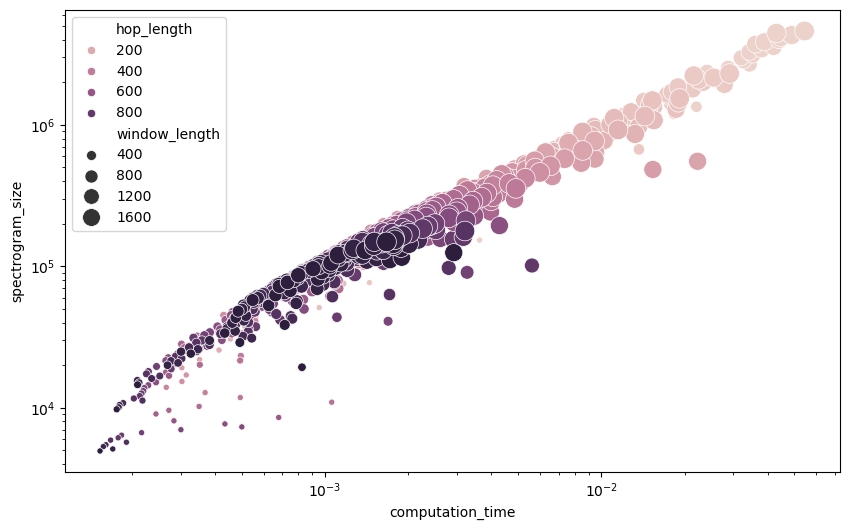

In [52]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=computation_times,
    x="computation_time",
    y="spectrogram_size",
    size="window_length",
    hue="hop_length",
    sizes=(20, 200),
)
ax.set_xscale("log")
ax.set_yscale("log")

Notice that although spectrogram computation is generally fast, the differences in processing time between settings can exceed an order of magnitude.
When scaling up to millions of recordings, a tenfold increase in computation time becomes highly significant.

Similarly, the size of the resulting spectrograms can vary by up to two orders of magnitude.
Because spectrograms are often used as inputs to deep learning models, their dimensions directly influence model size: larger inputs require models with more parameters, which in turn demand greater computational resources and can make training more difficult.

Here we have chosen to use the spectrogram as a visual representation of sound. Spectrograms are extremely useful transformations, both from a physical and biological perspective, since they capture how energy is distributed across frequencies over time. However, they represent only one of many possible ways to encode audio information.

When developing a deep learning model for audio (or for any type of data) it is important to consider alternative ways of generating representations or front-ends (so called because they sit at the beginning of the deep learning pipeline).

In audio analysis, for instance, one could provide the model with the raw waveform (a long sequence of amplitude values) or use other transformations that resemble a spectrogram but use a logarithmic frequency scale on the y-axis. 
Each representation captures different aspects of the signal and may be more or less suitable depending on the task.

In general, this is one place where domain expertise can make a difference: you can use your understanding of the sound source to choose a representation that may be particularly informative for the task, or alternatively, you can rely on the model itself to learn useful features directly from the raw data.

**🛑 Group Discussion**

Pause here and reflect on the following questions about your own research. We'll discuss together as a group.

1. What data are you planning to work with?
2. How is your data represented? Are there alternative representations worth considering before starting your machine learning workflow?
3. What characteristics or features of your data might be important to emphasize when choosing a representation?
4. What practical factors (e.g., processing speed, memory usage, or dataset size) might influence your choices or the feasibility of your approach?

### 3.2 Detecting Sounds

As you can imagine, it is not easy to manually annotate all relevant sounds in a recording.

Take a look at this recording:

In [53]:
YUCATAN_METADATA = DATA_DIR / "yucatan" / "yucatan_metadata.csv"

YUCATAN_AUDIO_DIR = DATA_DIR / "yucatan" / "audio"

# Load metadata of dataset of bat recordings from the Yucatan peninsula
yucatan = pd.read_csv(YUCATAN_METADATA)

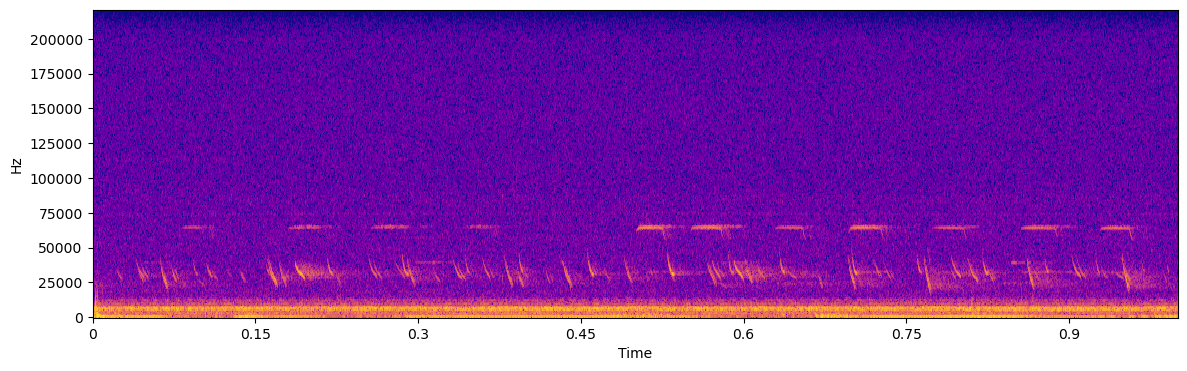

In [54]:
crowded_recording = YUCATAN_AUDIO_DIR / yucatan.id[1017]

plotting_utils.plot_spectrogram(
    crowded_recording, hop_length=128, n_fft=512, figsize=(14, 4)
)

There are many bat calls in this recording, and it would be very time-consuming to annotate them
all.

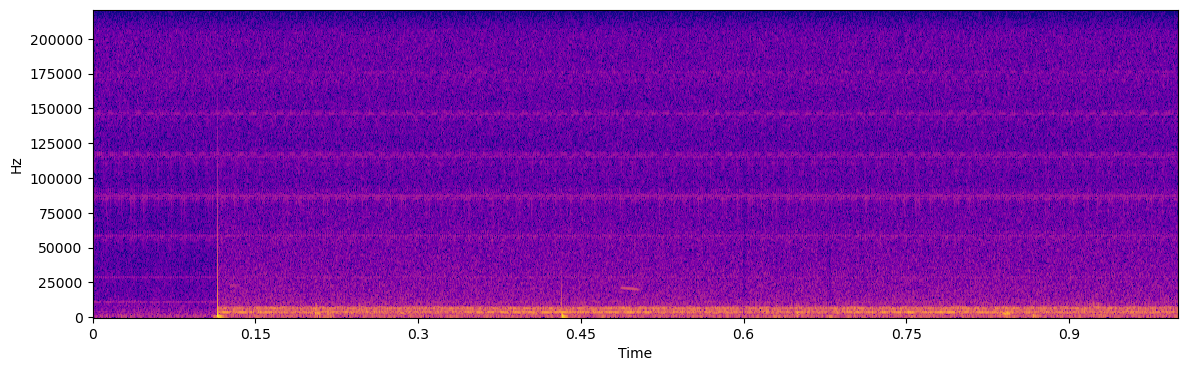

In [55]:
empty_recording = YUCATAN_AUDIO_DIR / yucatan.id[205]
plotting_utils.plot_spectrogram(
    empty_recording, hop_length=128, n_fft=512, figsize=(14, 4)
)

This other recording has a single bat pulse. You still need to review it thoroughly to make sure
there are no other sounds of interest.

Let’s briefly think about annotation. Imagine you are developing a model to automatically detect bats in passive acoustic recordings, though the same ideas apply to many other machine learning tasks in research.

You might already have a set of recordings and a team of experts (perhaps just yourself) who can identify bat species acoustically in your region.
How would you set up an annotation project and provide clear instructions to ensure that annotations are consistent and aligned with your machine learning goals?

In general, you should consider the following when designing annotation guidelines for your team:

1. What counts as a target sound?
Clearly define the type of sound or event you want to annotate (e.g. bat echolocation calls, social calls, or background noise).

2. How should each target sound be annotated?
Decide on the level of granularity—are annotators labelling presence/absence, or drawing precise boxes around each call? The choice affects both effort and the usefulness of the annotations.

3. What defines a complete annotation?
Specify the criteria that determine when a recording or segment is fully annotated.

4. How should ambiguous cases be handled?
Ambiguities often arise due to unusual sounds or borderline cases. Reviewing a diverse sample of recordings can help preempt confusion. Plan how to document or resolve ambiguous examples.

5. How can you ensure consistency across annotators and sessions?
Consider strategies such as shared examples, calibration sessions, or inter-annotator agreement checks.

Similar to **MegaDetector** for camera traps, there are some tools that automatically detect animal
sounds in recordings.

Various models have been developed and trained for different taxon groups. The following are very
popular examples, all using deep learning:

#### Birds

**BirdNET:** A convolutional neural network from Cornell University for classifying over 5,000 bird
calls in audio recordings.
> Kahl, S., Wood, C.M., Eibl, M. and Klinck, H., 2021. BirdNET: A deep learning solution for avian
> diversity monitoring. Ecological Informatics, 61, p.101236.
> [https://www.sciencedirect.com/science/article/pii/S1574954121000273](https://www.sciencedirect.com/science/article/pii/S1574954121000273)

[GitHub](https://github.com/kahst/BirdNET-Analyzer)

**Perch:** Similar idea; model trained on over 10,000 species.
[GitHub](https://github.com/google-research/perch)

#### Bats

**BatDetect2:** A framework in PyTorch for simultaneous detection and classification of UK bats.
> Aodha, O.M., Martínez Balvanera, S., Damstra, E., Cooke, M., Eichinski, P., Browning, E.,
> Barataud, M., Boughey, K., Coles, R., Giacomini, G. and Swiney G, M.C.M., 2022. Towards a general
> approach for bat echolocation detection and classification. bioRxiv, pp.2022-12.
> [https://www.biorxiv.org/content/10.1101/2022.12.14.520490v1.abstract](https://www.biorxiv.org/content/10.1101/2022.12.14.520490v1.abstract)

[GitHub](https://github.com/macaodha/batdetect2)

Below, we will use BatDetect2 on our data. Although the model was trained on UK bat calls, we can
still test its detection performance on the dataset of bats from the Yucatán peninsula.

💡 Make sure to use a GPU runtime for this. Even so, completion may take a while as we have quite a
number of audio recordings to analyse.

💡 BatDetect2 internally computes spectrograms to detect and classify bat calls, just like we
manually did above ([source
code](https://github.com/macaodha/batdetect2/blob/2100a3e483116037c57698c72bbe506c604ebd0b/batdetect2/train/audio_dataloader.py#L521)).

**BatDetect2** can predict multiple bounding boxes for each recording. Each bounding box has a
**score**, a predicted species and a confidence score for the species.

Here, we will throw out the predicted species and confidence score, and only use the bounding box
score. The **score** is the model's confidence that the bounding box contains a bat echolocation call.

In [ ]:
# List all files in the yucatan audio directory
files = api.list_audio_files(DATA_DIR / "yucatan" / "audio")

# Read each prediction file
batdetect2_predictions = []
for path in tqdm(files):
    # Run batdetect2 over the file
    output = api.process_file(path)

    # Collect the info we need from each model detection
    pred_dict = output["pred_dict"]
    for detection in pred_dict["annotation"]:
        batdetect2_predictions.append(
            {
                "recording_id": pred_dict["id"],
                "det_prob": detection["det_prob"],
                "start_time": detection["start_time"],
                "end_time": detection["end_time"],
                "low_freq": detection["low_freq"],
                "high_freq": detection["high_freq"],
            }
        )

# And convert them into a single dataframe
batdetect2_predictions = pd.DataFrame(batdetect2_predictions)

# show the first few rows of predictions made by BatDetect2
batdetect2_predictions.head()

Are these good predictions? To find out, we need to compare them to ground truth.

Let us load some previously made ground truth annotations first.

In [ ]:
# Load the annotations file
yucatan_annotations = pd.read_csv(DATA_DIR / "yucatan" / "yucatan_annotations.csv")

# show the first few rows
yucatan_annotations.head()

In [ ]:
yucatan_annotations['event'].value_counts()

In [ ]:
pd.crosstab(yucatan_annotations['event'], yucatan_annotations['class']).T

Now, we can compare the detections with the ground truth. We can use the Intersection-over-Union
(IoU) to measure the overlap between the detections and the ground truth.

<img alt="intersection over union"
src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png"
width="400"></img>

Intuitively, the relationship between overlap (intersection) and union tells us how geometrically
similar two bounding boxes are. An IoU of 1 means that both boxes are congruent (perfectly
overlapping), for IoU 0 the two boxes don't even touch each other.

We usually cannot expect a machine learning model to always produce perfectly identical bounding
boxes as provided in the ground truth. Hence, we need to set a minimum IoU value for which
we count a prediction as "correct". We will use such an _IoU threshold_ of 0.5 below.

In [ ]:
# Select the predictions and annotations from the crowded recording
file_detections = batdetect2_predictions[
    batdetect2_predictions.recording_id == crowded_recording.name
]
file_annotations = yucatan_annotations[
    yucatan_annotations.recording_id == crowded_recording.name
]

# Match the bounding boxes by computing the IoU. Discard all matches with IoU less than 0.5
pred_boxes = evaluation_utils.bboxes_from_annotations(file_detections)
true_boxes = evaluation_utils.bboxes_from_annotations(file_annotations)
matches = evaluation_utils.match_bboxes(true_boxes, pred_boxes, iou_threshold=0.5)

We can now distinguish three different cases (remember from the previous notebook):
* **True Positives (TP)**: _detections_ with IoU >= threshold
* **False Positives (FP)**: _detections_ with IoU < threshold
* **False Negatives (FN)**: _annotations_ with no matching detection

In [ ]:
# total number of annotated sound events
positives = len(file_annotations)

num_predictions = len(file_detections)

# number of matched prediction boxes
true_positives = len(matches)

# number of predicted boxes that were not matched
false_positives = num_predictions - len(matches)

# number of annotated sound events that were not matched
false_negatives = positives - len(matches)

With this information, we can compute the precision and recall of the detections:
$$
\text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

$$
\text{Recall} = \frac{\text{TP}}{\text{TP + FN}}
$$

In [ ]:
# Percentage of predictions that are correct
precision = true_positives / num_predictions

# Percentage of sound events that were detected
recall = true_positives / positives

print(
    f"BatDetect2 precision={precision:.1%} recall={recall:.1%} on file {crowded_recording.name}"
)

Now, we can visualise predictions and ground truth annotations in the spectrograms together:

In [ ]:
score_threshold = 0.2
iou_threshold = 0.1

plotting_utils.plot_spectrogram_with_predictions_and_annotations(
    crowded_recording,
    batdetect2_predictions[batdetect2_predictions.det_prob > score_threshold],
    yucatan_annotations,
    iou_threshold=iou_threshold,
)

In the visualisation above, bounding boxes are drawn in different styles:
- red = spurious predicted sound event (false positive)
- green = correct prediction (true positive)
- white = missed sound event (false negative)

Besides an IoU threshold, you will notice that we also need to set a _confidence threshold_, because
as explained above, BatDetect2 provides a confidence score.

We have set this rather arbitrarily to 0.3 above. You can imagine what happens if we increase or
decrease this threshold. Watch what happens for different files when you adjust IoU and confidence
thresholds in the widget below.

In [ ]:
# @title Batdetect2 predictions

# @markdown Select a file and an IoU threshold.

example_files = [
    YUCATAN_AUDIO_DIR / row["id"] for _, row in yucatan.sample(n=20).iterrows()
]


@widgets.interact(
    path=[(path.name, path) for path in example_files],
    iou_threshold=(0, 1, 0.025),
    score_threshold=(0, 1, 0.025),
)
def plot_batdetect2_results_file_results(
    path=crowded_recording,
    iou_threshold=0.5,
    score_threshold=0.3,
):
    confident_detections = batdetect2_predictions[
        batdetect2_predictions.det_prob > score_threshold
    ]

    precision, recall = evaluation_utils.compute_file_precision_recall(
        path,
        confident_detections,
        yucatan_annotations,
        iou_threshold=iou_threshold,
    )

    print(
        f"Batdetect2 precision={precision:.1%} recall={recall:.1%} on file {path.name}"
    )

    plotting_utils.plot_spectrogram_with_predictions_and_annotations(
        path,
        confident_detections,
        yucatan_annotations,
        iou_threshold=iou_threshold,
        linewidth=1,
    )

🖌️ With the code blocks above as help, implement the calculation of the following properties below:

* The mean precision and recall across all files.
* The percentage of files where all bat calls were missed.

In [ ]:
precisions, recalls = [], []  # lists of per-file precision and recall scores
files_missed = 0  # counter for number of files where all calls were missed


for recording_id in batdetect2_predictions.recording_id.unique():
    file_detections = batdetect2_predictions[
        batdetect2_predictions.recording_id == recording_id
    ]
    file_annotations = yucatan_annotations[
        yucatan_annotations.recording_id == recording_id
    ]

    # Match the bounding boxes by computing the IoU. Discard all matches with IoU less than 0.5
    pred_boxes = evaluation_utils.bboxes_from_annotations(file_detections)
    true_boxes = evaluation_utils.bboxes_from_annotations(file_annotations)
    matches = evaluation_utils.match_bboxes(true_boxes, pred_boxes, iou_threshold=0.5)

    # total number of annotated sound events
    positives = len(file_annotations)

    num_predictions = len(file_detections)

    # number of matched prediction boxes
    true_positives = len(matches)

    # number of predicted boxes that were not matched
    false_positives = num_predictions - len(matches)

    # number of annotated sound events that were not matched
    false_negatives = positives - len(matches)

    # Percentage of predictions that are correct
    if num_predictions == 0:
        precision = 0
    else:
        precision = true_positives / num_predictions

    # Percentage of sound events that were detected
    if positives == 0:
        recall = 0
    else:
        recall = true_positives / positives

    precisions.append(precision)
    recalls.append(recall)

    # increment counter if all bat calls were missed
    if true_positives == 0 and positives > 0:
        files_missed += 1

print(
    f"Mean precision = {np.mean(precisions):.2%}, Mean recall = {np.mean(recalls):.2%}."
)
print(
    f"Percent of files where all bat calls were missed = {files_missed/len(precisions):.2%}."
)

🖌️ Run the full evaluation again but change the `iou_threshold` parameter. What do you observe?

* Increasing the **IoU threshold** makes it harder to find matches (`true_positives`). Recall will
  necessarily be lowered, as less bat calls can be detected. Precision will also be lowered as less
  detections can be correct.

* Conversely, a lower **IoU threshold** increases the number of matches (`true_positives`), making
  both recall and precision greater.

* Selecting an **IoU threshold** is not about optimizing performance, but about choosing a matching
  criterion. Having a low **IoU** threshold might increase the recall and precision but incurr a
  cost in precision of the bounding box of each detection.

We can visualise BatDetect2's predictions versus ground truth labels for a selection of audio files
below.

In [ ]:
# @title Batdetect2 predictions

# @markdown Select a file and an IoU threshold.

example_files = [
    YUCATAN_AUDIO_DIR / row["id"] for _, row in yucatan.sample(n=20).iterrows()
]


@widgets.interact(
    path=example_files,
    iou_threshold=(0, 1, 0.1),
    score_threshold=(0, 1, 0.1),
)
def plot_batdetect2_results_file_results(
    path=crowded_recording,
    iou_threshold=0.5,
    score_threshold=0.3,
):
    confident_detections = batdetect2_predictions[
        batdetect2_predictions.det_prob > score_threshold
    ]

    precision, recall = evaluation_utils.compute_file_precision_recall(
        path,
        confident_detections,
        yucatan_annotations,
        iou_threshold=iou_threshold,
    )

    print(
        f"Batdetect2 precision={precision:.1%} recall={recall:.1%} on file {crowded_recording}"
    )

    plotting_utils.plot_spectrogram_with_predictions_and_annotations(
        path,
        confident_detections,
        yucatan_annotations,
        iou_threshold=iou_threshold,
        linewidth=2,
    )

**🛑 Group Discussion**

In this section, we explored how to evaluate the performance of BatDetect2 in identifying echolocation pulses using metrics such precision, and recall.
These evaluation metrics summarise model performance across many examples, and each one captures only a specific aspect of that behavior.
For example, we did not evaluate how closely the predicted bounding boxes align with expert annotations.

Take a moment to reflect on the following questions before we discuss as a group:

1. For the machine learning tasks in your research, which evaluation metrics are available, and which ones are most commonly used?
2. Do these metrics align with your broader research goals? Metrics are often adopted because they are standard in ML research, but they may not fully reflect, or provide a holistic view of, your ecological or scientific objectives.
3. Who are the potential users of your research outputs? If you've identified them, what information would they need to make informed decisions about how and when to use your results?

---

## 4. Identifying Sounds

In the previous section, we saw how to detect sounds in a recording. But we still need to identify
the species that produced the sound.

Generally, classification is more challenging than detection, as the sounds produced by different
species can be very similar (**interspecific overlap**). Also, a single species can have flexible
vocalisations, think humans or mimic birds such as starling (**intraspecific variation**).

Bioacoustic data presents similar challenges to the camera trap datasets as recordings can be:
* **Ocluded** (Simultaneous sounds)
* **Appear in varying ambient conditions** (rain/wind/thunder)
* **Partial** (Only captured half the sound)
* **Noisy** (Saturation and faulty sensor)
* **Quiet or very loud** (depending on animal size, distance, environment)

For the rest of this notebook we will focus on **10** bat species present in the Yucatán dataset.

In [ ]:
SPECIES = [
    "Mormoops megalophylla",
    "Myotis keaysi",
    "Saccopteryx bilineata",
    "Pteronotus davyi",
    "Pteronotus parnellii",
    "Lasiurus ega",
    "Pteropteryx macrotis",
    "Eumops underwoodi",
    "Rhogeessa aeneus",
    "Eptesicus furinalis",
]

classification_df = yucatan_annotations[yucatan_annotations["class"].isin(SPECIES)]

### 4.1 Bat Call Features

Previous research on bat call identification was based on hand-crafted features of the bat calls.
Measuring call features used to be a manual process.

<img src="https://www.elekon.ch/batexplorer2/doc/_images/CallParams.png" alt="call parameters" width="400"/>

> Image taken from the [BatExplorer 2.1 user guide](https://www.elekon.ch/batexplorer2/doc/batcall_params.html).

**Peak frequency [kHz]:**

>    The frequency at which the call is loudest (peak in the spectrum display), aka frequency of maximum energy (FME) or main frequency.
>    Most important parameter for bat classification because it can easily be measured and is often typical for a certain species or group of species.
>    The standard deviation of the peak frequency allows the detection of alternating calling species.
    
**Max frequency [kHz]**

>    The maximum frequency of the call. Often this is equal to the start frequency, for Rhinolophidae typically equal to the peak frequency.
    
**Min frequency [kHz]**

>    The minimum frequency of the call. Often this is equal to the end frequency, for hockey stick calls (e.g. Pipistrelle) it might be lower than the end frequency.
    
**BW Peak2Min [kHz]**

>    Bandwidth Peak2Min = Peak frequency - Min frequency
>    Often used to distinguish Myotis and Pipistrelle calls, Myotis mostly have higher bandwidth.
    
**Call length [ms]**

>    Time period of call start to call end in ms. Can be measured most accurately in the oscillogram (wave rise to wave drop).
>    Search calls from European bats are usually between one and up to approximately 30 ms (horseshoe bats up to 80 ms).
    
**Call distance [ms]**

>    Time period between two consecutive calls in ms. Can be measured most accurately in the oscillogram (wave rise call A to wave rise call B).
>    Often this parameter is not very significant since most bat species have irregular rhythms. But it can be an indicator for behavior.
>    Search calls from European bats usually have distances of about 30 to 300 ms, sometimes even longer.


### 4.2 Classifying Sounds with Transfer Learning

In Section 3, we used BatDetect2 to localise bat calls within spectrograms.
However, we could not use its predicted species, since those are from the UK and
do not occur in Yucatán (and BatDetect2 does not know about the latter's species
either).

If we want to do both, _i.e._, detect _and_ classify bat calls, we now have two options:

1. Retrain BatDetect2 on the Yucatán dataset, either from scratch or by adapting
the UK-trained model. However, this approach often requires a large number of
labelled samples and careful fine-tuning, which may not always be feasible.

2. Train a simpler classifier that uses a set of features extracted from each
call to predict the species.

In the following, we will explore the second approach. This strategy is often
preferred in bioacoustics, where training large deep learning models can be
technically demanding and data-hungry.

Traditionally, such classifiers rely on hand-crafted features, measurements
identified by bat experts to help distinguish between species, like the ones
above. However, obtaining these features can be time-consuming and sometimes
requires manual annotation. Moreover, these features have mainly been explored
for a relatively small set of mostly temperate-region species, and even then,
they do not always allow us to reliably separate acoustically similar species.

Because our understanding of bat acoustics is still incomplete, it is likely
that there are additional, informative features that experts have not yet
identified. A data-driven approach, where we learn useful features directly from
the data, offers a powerful alternative. This is exactly what modern deep
learning models do: during training, they automatically learn to compute
internal representations, also called embeddings, that capture meaningful
characteristics of the input sounds.

We can take advantage of this by using a pre-trained model to extract such
features from our bat recordings. Even if the model was not trained
specifically on bat data, a network trained on a large and diverse audio dataset
should have learned to capture broad, universal acoustic patterns. By using
these embeddings as input features, we effectively **transfer** the model’s learned
knowledge to a new but related task, in this case classifying bat calls.

If the deep learning model can summarise the spectrogram contents “well enough,”
we can then train a lightweight classifier, such as a Random Forest, to predict
the target species more easily.

To do so, we will use a general-purpose acoustic feature extractor called
[Yamnet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet).

Yamnet was trained on [AudioSet](http://research.google.com/audioset/) a massive dataset of YouTube
recordings with more than 5.8 thousand hours of audio.

It was trained to classify sounds clips into 527 different classes. The features it learned to
extract are thus useful to distinguish and identify a large variety of sounds.

<img src="http://research.google.com/audioset/resources/histogram.svg" alt="audioset dataset"
width="400"/>

Audioset does not contain ultrasonic recordings, and thus is devoid of bat sounds. However, we
hope that the learnt features are sufficiently general that it can help identify bat calls.

First, we need to download the model. The model is available in [TensorFlow Hub](https://tfhub.dev/), a repository of pre-trained models.

In [ ]:
# load the model using tensorflow_hub
yamnet = hub.load("https://tfhub.dev/google/yamnet/1")

Next, we will load all the audio bits from the dataset and extract the features using the model.

YamNet was originally trained with 0.96 second audio clips sampled at 16kHz, corresponding to $0.96 \times 16000=15360$ individual audio samples.
However, all our recordings have a sample rate of 44.1kHz. Hence, we will only feed the model with 34ms of audio at a time, equivalent to the same 15360 samples.

We will center each audio clip on the bat calls.

In [ ]:
# Here we will load the information of where each bat call starts and ends
audio_clips = pd.read_csv(DATA_DIR / "yucatan" / "yucatan_species_clips.csv")

In [ ]:
def load_annotation_audio(row, num_samples: int, time_buffer: float = 0.01):
    # Add a bit of extra audio padding to the left and right of the annotated call
    start_time = row.start_time - time_buffer
    end_time = row.end_time + time_buffer

    # Load only the audio between the declared start and end time
    audio, _ = audio_utils.load_audio(
        path=str(YUCATAN_AUDIO_DIR / row.recording_id),
        start_time=start_time,
        end_time=end_time,
    )

    if audio.ndim > 1:
        # Pick the first audio channel only
        audio = audio[:, 0]

    if len(audio) > num_samples:
        # If the audio is longer than the number of samples needed, cut it to size
        return audio[:num_samples]

    if len(audio) < num_samples:
        # If the audio is too short, then we need to pad it with silence at the end
        return np.pad(
            audio,
            [
                [0, num_samples - len(audio)],
            ],
            mode="constant",
            constant_values=0,
        )

    return audio

Let's calculate feature vectors with YamNet for each of our bat calls.

In [ ]:
yamnet_features = []
for _, row in tqdm(audio_clips.iterrows(), total=len(audio_clips)):
    # Extract audio from around the call
    wav = load_annotation_audio(row, num_samples=int(0.96 * 16_000))

    # Process with yamnet
    scores, feats, spectrogram = yamnet(wav)

    # Store the extracted features
    yamnet_features.append(feats.numpy().squeeze())

yamnet_features = np.array(yamnet_features)

Note that YamNet returns a set of 1,024 features for each audio clip:

In [ ]:
print(yamnet_features.shape)

We don't know yet whether those features are actually useful for separating our Yucatán bat species.
Thus, we can first visualise the features using a dimensionality reduction technique, [UMAP](https://umap-learn.readthedocs.io/en/latest/).

In [ ]:
umap_yamnet = UMAP().fit_transform(StandardScaler().fit_transform(yamnet_features))

In [ ]:
X, Y = umap_yamnet.T
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X, y=Y, hue=audio_clips["class"])

It seems difficult to disentangle bat species based on the feature sets and this UMAP plot. Well,
let us nonetheless try and use those features as input for a classifier to really see how well it
will work.

Here you will build a Random Forest classifier using the features extracted by YamNet.

🖌️ Split the data into train and test. Use 30% of the data for testing purposes.

In [ ]:
# split the data into train and test
from sklearn.model_selection import train_test_split

X_train_yamnet, X_test_yamnet, y_train_yamnet, y_test_yamnet = train_test_split(
    yamnet_features,
    audio_clips["class"],
    test_size=0.3,
    stratify=audio_clips["class"],  # notice we are using the stratified argument
)

🖌️ Train a random forest classifier using the training data.

In [ ]:
# build a random forest model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

# fit to training data
rf.fit(X_train_yamnet, y_train_yamnet)

This time, we will use cross-validation instead of a dedicated validation set. Scikit-learn has a
handy function
[cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
available for us.

🖌️ Implement cross-validation by completing the code cell below. Then, tweak the Random Forest's
hyperparameters based on this result until you are happy to move on to the test set.

In [ ]:
from sklearn.model_selection import cross_val_score

# create new Random Forest object
rf = RandomForestClassifier(n_estimators=500)

# calculate crossvalidation (CV) performance scores
scores = cross_val_score(rf, X_train_yamnet, y_train_yamnet, cv=5)

# report CV score statistics
print(f"CV score mean: {scores.mean():.2%}, std: {scores.std():.2%}.")

🖌️ Once you are happy enough with the performance, evaluate the performance using the
`classification_report` function.

In [ ]:
# we still need to fit the final model
rf.fit(X_train_yamnet, y_train_yamnet)

# predict on the test set
y_pred_yamnet = rf.predict(X_test_yamnet)

# evaluate using the classification_report
print(classification_report(y_true=y_test_yamnet, y_pred=y_pred_yamnet))

🖌️ Plot the confusion matrix. Tip: check the [scikit-learn
documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [ ]:
# compute the confusion matrix and normalise each row to get percentages
cm = confusion_matrix(y_true=y_test_yamnet, y_pred=y_pred_yamnet, normalize="true")

_, ax = plt.subplots(figsize=(8, 8))

# plot the confusion matrix using the ConfusionMatrixDisplay
ConfusionMatrixDisplay(cm, display_labels=rf.classes_).plot(
    xticks_rotation="vertical", values_format=".0%", ax=ax
);

🖌️ Which are the worst performing species? Can you see why? You might need to go back and see some
more examples of bat calls.

💡 **Caveat**: Answers are likely to be different each run, as dataset splits and random forest
training are random.

*Mormoops megalophylla* and *Eumops underwoodi* were the worst-performing species.

This could be explained by:
* Low number of examples (see "support" in accuracy report table). Note that this is especially
  problematic given YamNet produces a 1024-dimensional feature vector. With insufficient numbers of
  examples we run into the **curse of dimensionality** issue.
* Related to this is class imbalance, respectively long-tailed class distribution in general.
  Although this affects Random Forests less than _e.g._ deep learning models, it can still cause
  mayhem.
* Little clustering and insufficient separation of YamNet features (see UMAP scatter plot).
* Difficult call signature overall (see visualisations of spectrogram).

From an ecological perspective:

* The training examples might not cover the whole range of call variation. Test calls could contain
  call types not seen during training. This could be fixed by collecting more data, or generating
  synthetic data.
* There also seems to be substantial overlap between echolocation calls of different species. This
  could be due to errors in labelling. Errors in the annotation process are common and should be
  expected. This could be fixed by conducting a review process in which suspicious annotations are
  verified or corrected. An annotation can be flagged as suspicious if its features lie far from the
  usual distribution (_outlier detection_), or if the model is confidently wrong about its class (_hard
  example mining_).
* Bat echolocation calls are are used to navigate and detect pray. If habitual flying space and/or
  prey are similar for two species they will tend to echolocate in a similar fashion. When this is
  the case using a different classification scheme for bats, such as one based on ecological traits,
  might be better suited for the task of acoustic identification.
* Sound production is also constrained by morphology. Closely related species will tend to have
  similar sound production capabilities and thus similar echolocation calls. However, this is not
  always the case as echolocation call is heavily constrained by ecology (as mentioned in the
  previous point). A potential workaround is to classify to a higher taxonomic level such as genus
  or family.
* Selected call features cannot discern between species. It could be the case
  that there are subtle cues in the audio that aid identification but haven't been
  measured. We extracted features using YAMNet, which may not represent the
  information contained in echolocation calls accurately. Since YAMNet was not
  trained on ultrasonic data, it may fail to capture critical characteristics of
  these high-frequency signals.

### 4.3 Specialised Features with Perch

The above solution did not really work that well. As you have seen in the UMAP plot, the YamNet
features do not sufficiently capture the patterns in the data to be able to separate calls by bat
species.

However, above we also talked about another model that has been trained more for acoustic data:
[Perch](https://github.com/google-research/perch/tree/main). What if we use its features
instead of YamNet?

First, let's calculate those. Perch is also
[available](https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/8)
in TensorFlow Hub:


In [ ]:
# load model
model_perch = hub.load(
    "https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/8"
)

Perch however does differ from Yamnet in how it outputs features (and predictions) as it consumes 5 seconds of audio at 32kHz, equivalent to $5 \times 32000 = 160000$ audio samples.

In [ ]:
perch_features = []
for _, row in tqdm(audio_clips.iterrows(), total=len(audio_clips)):
    # load audio data into memory
    wav = load_annotation_audio(row, num_samples=int(5 * 32_000))

    # predict using Perch
    model_outputs = model_perch.infer_tf(wav[None, :])

    # extract and append features (also known as "embeddings")
    perch_features.append(model_outputs["embedding"])

# combine features into single NumPy array
perch_features = np.array(perch_features).squeeze()

Let's print the shape of the Perch features:

In [ ]:
print(perch_features.shape)

Slightly larger than YamNet (1280 _vs._ 1024), but are they any better?

🖌️ Redo the above steps including calculation of UMAP plot and training and evaluation using Random
Forest.

In [ ]:
# create UMAP plot
umap_perch = UMAP().fit_transform(StandardScaler().fit_transform(perch_features))
X, Y = umap_perch.T
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X, y=Y, hue=audio_clips["class"])

In [ ]:
# split into train/test sets
X_train_perch, X_test_perch, y_train_perch, y_test_perch = train_test_split(
    perch_features,
    audio_clips["class"],
    test_size=0.3,
    stratify=audio_clips["class"],  # notice we are using the stratified argument
)


# create new Random Forest object
rf = RandomForestClassifier(n_estimators=500)

# calculate crossvalidation (CV) performance scores
scores = cross_val_score(rf, X_train_perch, y_train_perch, cv=5)

# report CV score statistics
print(f"CV score mean: {scores.mean():.2%}, std: {scores.std():.2%}.")

# train final model
rf.fit(X_train_perch, y_train_perch)

# predict on the test set
y_pred_perch = rf.predict(X_test_perch)

# evaluate using the classification_report
print(classification_report(y_true=y_test_perch, y_pred=y_pred_perch))

# compute the confusion matrix and normalise each row to get percentages
cm = confusion_matrix(y_true=y_test_perch, y_pred=y_pred_perch, normalize="true")

_, ax = plt.subplots(figsize=(8, 8))

# plot the confusion matrix using the ConfusionMatrixDisplay
ConfusionMatrixDisplay(cm, display_labels=rf.classes_).plot(
    xticks_rotation="vertical", values_format=".0%", ax=ax
)

**🛑 Group Discussion**

Again have a think about the following questions:

1. Has your field already identified clear features that can be used to distinguish between different states or predict the presence of certain patterns? If so, are there any challenges that have been identified with those?
2. Are there existing models that you could use to extract features and perform transfer learning for your research? If so, think about what data they were trained on and whether there are significant differences between your data and theirs.
3. Do you think transfer learning is not applicable to your dataset? If so, why?

### 4.4 Active Learning: Cutting Annotation Costs

High-quality annotations are notoriously labor-intensive in bioacoustics. Meanwhile, Passive Acoustic Monitoring (PAM) continues to generate massive unlabeled datasets. **How can we build fast classifiers without expensive manual annotation?** When hunting for specific vocalizations, combining **transfer learning** with a **human-in-the-loop** approach (active learning) allows us to build an agile classifier in a fraction of the time. 

#### The Agile Modeling Workflow

Instead of training a model from scratch, we start with three inputs: a high-quality embedding model (like Google's **Perch**), unlabeled audio data, and a tiny "seed" set of target sounds.

1. **Extract Features:** Compute the embeddings for both the unlabeled dataset and the target sounds to create a compressed mathematical representation (features) of your audio.
2. **Vector Search:** Compare embeddings to find unlabeled audio clips that closely match your target sound. For example, the spectrograms below show how the algorithm uses one known example of a hairy woodpecker (left) to successfully detect similar drumming sounds (blue) hidden amidst heavy background noise (brown): ![search](https://docs.google.com/drawings/d/e/2PACX-1vSIwCEkHNEjtyh3PLhTa-4hTTaBoMnWGVXobr91rKeD7m52a4ES9K0JZ_tqltasUWctgLHnf2PrvtKU/pub?w=371&h=253)
3. **Human Annotation:** Review a small batch of these top proposals (e.g., 20–50 clips) and simply accept or reject them. 
4. **Lightweight Training:** Train a fast linear classifier (e.g., Logistic Regression) on the newly verified embeddings. 
5. **Iterate:** Use the new classifier to surface another batch of proposals. Repeat steps 3–5 until performance reaches your desired threshold.
  

> 💡 **The Advantage:**
> * **Computationally Efficient:** You only compute embeddings once. Training a linear classifier on those embeddings takes seconds, completely avoiding expensive neural network retraining.
> * **Highly Adaptable:** This workflow is species-agnostic and can be used to isolate sounds across any taxonomic group.

For details on the agile modelig for bioacoustics, refer to the original source:

    Dumoulin, V., Stretcu, O., Hamer, J., Harrell, L., Laber, R., Larochelle, H., ... & Denton, T. (2025). The search for squawk: Agile modeling in bioacoustics. arXiv preprint arXiv:2505.03071. https://arxiv.org/abs/2505.03071


##### Anuraset - Site INCT17


This dataset is a subset of the Anuraset dataset, specifically comprising recordings collected at site INCT17 in the Cerrado biome.
It consists of 1-minute-long passive acoustic recordings.
All recordings were reviewed by expert herpetologists, and frog calls were manually annotated with species labels along with their onset and offset times.
For details on the full dataset and audio collection process, refer to the original source:

    Cañas, J.S., Toro-Gómez, M.P., Sugai, L.S.M. et al. A dataset for benchmarking Neotropical anuran calls identification in passive acoustic monitoring. Sci Data 10, 771 (2023). https://doi.org/10.1038/s41597-023-02666-2


Here we describe how the data is organized.

- `strong_labels.csv`.
  Contains detailed expert annotations of individual frog calls.
  Columns:

  - `file_id`: Identifier of the recording.
  - `start_time`: Onset time of the call (in seconds).
  - `end_time`: Offset time of the call (in seconds).
  - `species`: Identified frog species.
  - `quality`: Subjective evaluation of call quality (e.g., noisy or clean).

- `audio/`
  - Contains all recordings in FLAC format (to reduce file size).
  - Each recording is stored as `<file_id>.flac`, with the second audio channel removed from the original recording.

-  `species.csv`.
  - `FAMILY`: Taxonomic family name
  - `SPECIES`: Taxonomic Species name
  - `CODE`: Species code for annotation


Some examples of the annotations and the calls in the next figure:

![image.png](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41597-023-02666-2/MediaObjects/41597_2023_2666_Fig3_HTML.png?as=webp)



We will use perch-hoplite package for agile modeling in bioacoustics.
Assume that we are only interested in one frog  for monitoring and
that we only have some examples of the data identified.
And the other are unlabeled data without any information about the species.


In [ ]:
ANURASET_AUDIO_DIR = DATA_DIR / "anuraset_17" / "audio"
ANURASET_STRONG_LABELS = DATA_DIR / "anuraset_17" / "strong_labels.csv"

In [ ]:
anuraset = pd.read_csv(ANURASET_STRONG_LABELS)

In [95]:
anuraset['species'].value_counts()

species
BOAALB    926
BOALUN    713
PHYCUV    260
PHYMAR     90
DENCRU     55
PITAZU     38
Name: count, dtype: int64

In [96]:
# Lets start with HYLIDAE,Boana albopunctata,BOAALB

#### Extract Features

In [ ]:
# @markdown 1. Create a unique name for the database that will store the embeddings for the
# @markdown target data.
dataset_name = 'anuraset'  # @param {type: 'string'}

# @markdown 2. Input the filepath for the folder that is containing the input audio files.
#dataset_base_path = '/Users/juancanas/Downloads/raw_data/INCT41'  # @param {type: 'string'}

dataset_base_path =  '/data/anuraset_17/audio'

# @markdown 3. Input the file pattern for the audio files within that folder that you want
# @markdown to embed. Some examples for how to input:
# @markdown - All files in the base directory of a specific type (not subdirectories): e.g.
# @markdown `*.wav` (or `*.flac` etc) will generate embeddings for all .wav files (or whichever
# @markdown format) in the `dataset_base_path`.
# @markdown - All files in one level of subdirectories within the base directory: `*/*.flac`
# @markdown will generate embeddings for all .flac files.
# @markdown - Single file: `myfile.wav` will only embed the audio from that specific file.
dataset_fileglob = '*/*.wav'  # @param {type:'string'}

# @markdown 4. [Optional] If saving the embeddings database to a new directory, specify here.
# @markdown Otherwise, leave blank - by default the embeddings database output will be saved
# @markdown within `dataset_base_path` where the audio is located. You do not need to specify
# @markdown `db_path` unless you want to maintain multiple distinct embedding databases, or
# @markdown if you would like to save the output in a different folder. If your input audio
# @markdown data is accessed from a public URL, we recommend specifying a separate output
# @markdown directory here.
db_path = '/tmp/anuraset_hoplite' #'/tmp/hoplite'  # @param {type:'string'}
if not db_path or db_path.lower() == 'none':
  db_path = None

# @markdown 5. Choose a supported model to generate embeddings. `perch_v2` is the latest Perch
# @markdown model and was trained on multiple taxa include birds, mammals, insects and amphibians.
# @markdown `perch_v2` has also demonstrated high performance for marine audio transfer learning
# @markdown tasks. **NOTE: `perch_v2` only works with GPU runtimes - see above instructions.**
# @markdown `perch_8` is the last updated version of Perch V1 trained only on birds, and
# @markdown `birdnet_v2.3` is also a common option for birds. Other choices include `surfperch`
# @markdown for coral reefs or `multispecies_whale` for marine mammals.
model_choice = 'perch_8'  # @param ['perch_v2', 'perch_8', 'humpback', 'multispecies_whale', 'surfperch', 'birdnet_V2.3']

# @markdown 6. [Optional] Shard the audio for embeddings. File sharding automatically splits audio
# @markdown files into smaller chunks for creating embeddings. This limits both system and GPU
# @markdown memory usage, especially useful when working with long files (>1 hour).
use_file_sharding = True  # @param {type:'boolean'}
# @markdown If you want to change the length in seconds for the shards, specify here.
shard_length_in_seconds = 60  # @param {type:'number'}

In [79]:
audio_glob = source_info.AudioSourceConfig(
    dataset_name=dataset_name,
    base_path=dataset_base_path,
    file_glob=dataset_fileglob,
    min_audio_len_s=1.0,
    target_sample_rate_hz=-2,
    shard_len_s=float(shard_length_in_seconds) if use_file_sharding else None,
)

configs = colab_utils.load_configs(
    source_info.AudioSources((audio_glob,)),
    db_path,
    model_config_key=model_choice,
    db_key='sqlite_usearch',
)
configs

AgileConfigs(audio_sources_config=AudioSources(audio_globs=(AudioSourceConfig(dataset_name='anuraset', base_path='/Users/juancanas/UCL/courses/BIOS0032/BIOS0032_AI4Environment/BioacousticsAI/data/anuraset/audio', file_glob='*/*.wav', min_audio_len_s=1.0, target_sample_rate_hz=-2, shard_len_s=60.0, max_shards_per_file=None),)), db_config=DBConfig(db_key='sqlite_usearch', db_config=db_path: data/anuraset_hoplite
usearch_cfg:
  dtype: float16
  embedding_dim: 1280
  expansion_add: 256
  expansion_search: 128
  metric_name: IP
), model_config=ModelConfig(model_key='taxonomy_model_tf', embedding_dim=1280, model_config=hop_size_s: 5.0
model_path: ''
sample_rate: 32000
tfhub_path: google/bird-vocalization-classifier/tensorFlow2/bird-vocalization-classifier
tfhub_version: 8
window_size_s: 5.0
, logits_key=None, logits_idxes=None))

In [80]:
# @title Initialize the hoplite database (DB) {vertical-output: true}

global db
db = configs.db_config.load_db()
num_embeddings = db.count_embeddings()

print('Initialized DB located at:', configs.db_config.db_config.db_path)

def drop_and_reload_db(_) -> interface.HopliteDBInterface:
  db_path = epath.Path(configs.db_config.db_config.db_path)
  for fp in db_path.glob('hoplite.sqlite*'):
    fp.unlink()
  (db_path / 'usearch.index').unlink()
  print('\n Deleted previous db at: ', configs.db_config.db_config.db_path)
  db = configs.db_config.load_db()

# @markdown If `drop_existing_db` set to True, when the database already exists and contains
# @markdown embeddings, then those existing embeddings will be erased. You will be prompted
# @markdown to confirm you wish to delete those existing embeddings. If you want to keep
# @markdown existing embeddings in the database, then set to False, which will append the new
# @markdown embeddings to the database.
drop_existing_db = False  # @param {type: 'boolean'}

if drop_existing_db:
  print('Existing DB contains projects: ', db.get_all_projects())
  print('num embeddings: ', num_embeddings)
  print('\n\nClick the button below to confirm you really want to drop the database at ')
  print(f'{configs.db_config.db_config.db_path}\n')
  print(f'This will permanently delete all {num_embeddings} embeddings from the existing database.\n')
  print('If you do NOT want to delete this data, set `drop_existing_db` above to `False` and re-run this cell.\n')

  button = widgets.Button(description='Delete database?')
  button.on_click(drop_and_reload_db)
  display(button)

Initialized DB located at: data/anuraset_hoplite


In [81]:
# @title Run the embedding {vertical-output: true}

print(f'Embedding dataset as a new db project: {audio_glob.dataset_name}')

worker = embed.EmbedWorker(
    audio_sources=configs.audio_sources_config,
    db=db,
    model_config=configs.model_config,
)

worker.process_all(target_dataset_name=audio_glob.dataset_name)

print('\n\nEmbedding complete, total embeddings: ', db.count_embeddings())

Embedding dataset as a new db project: anuraset

Adding deployments...


0it [00:00, ?it/s]



Adding recordings...


0it [00:00, ?it/s]



Adding annotations...

Embedding audio...


0it [00:00, ?it/s]



Embedding complete, total embeddings:  0


---

In [15]:
# @title Ingest ground truth annotations (if available)

if dataset_name in ingest_annotations.PRESETS:
  ingestor = ingest_annotations.PRESETS[dataset_name]
  class_counts = ingestor.ingest_dataset(db)
  db.commit()
  print("Ingested annotations:\n", class_counts)

2026-02-26 13:20:51.747275: W external/local_xla/xla/tsl/platform/cloud/google_auth_provider.cc:185] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".
100%|██████████| 1206/1206 [00:00<00:00, 2001.22it/s]


Inserted 0 labels.
Ingested annotations:
 defaultdict(<class 'int'>, {})


In [16]:
# @title Per project statistics {vertical-output: true}

for project in db.get_all_projects():
  window_ids = db.match_window_ids(
      deployments_filter=config_dict.create(eq=dict(project=project))
  )
  print('Project:', project)
  print('>>> num embeddings:', len(window_ids))
  print()

In [17]:
# @title Show example embedding search
# @markdown As an example (and to show that the embedding process worked), this selects a single
# @markdown embedding from the database and outputs the embedding ids of the top-k (k = 128)
# @markdown nearest neighbors in the database.

q = db.get_embedding(db.match_window_ids(limit=1)[0])
%time results, scores = brutalism.brute_search(worker.db, query_embedding=q, search_list_size=128, score_fn=np.dot)
print([int(r.window_id) for r in results])

IndexError: list index out of range

In [ ]:
# @title Load model and connect to database {vertical-output: true}

# @markdown Location of database containing audio embeddings.
#db_path = '/tmp/hoplite'  # @param {type: 'string'}

# @markdown Identifier (e.g. name) to attach to labels produced during validation.
annotator_id = 'linnaeus'  # @param {type: 'string'}

db = sqlite_usearch_impl.SQLiteUSearchDB.create(db_path)
db_model_config = db.get_metadata('model_config')
embed_config = db.get_metadata('audio_sources')
model_class = model_configs.get_model_class(db_model_config.model_key)
embedding_model = model_class.from_config(db_model_config.model_config)
audio_sources = source_info.AudioSources.from_config_dict(embed_config)
if hasattr(embedding_model, 'window_size_s'):
  window_size_s = embedding_model.window_size_s
else:
  window_size_s = 5.0
audio_filepath_loader = audio_loader.make_filepath_loader(
    audio_sources=audio_sources,
    window_size_s=window_size_s,
    sample_rate_hz=embedding_model.sample_rate,
)
     

In [99]:
anuraset[(anuraset['species']=='BOAALB')&(anuraset['quality']=='M')]

file_id  start_time   end_time species quality
1     INCT41_20201231_210000    0.000000  59.988753  BOAALB       M
33    INCT41_20201114_193000   10.006029  11.689508  BOAALB       M
36    INCT41_20201114_193000   15.103888  16.882210  BOAALB       M
69    INCT41_20210112_193000    0.000000  60.272164  BOAALB       M
74    INCT41_20201228_204500    0.000000  59.988753  BOAALB       M
...                      ...         ...        ...     ...     ...
2073  INCT41_20200213_203000    0.000000   1.381631  BOAALB       M
2074  INCT41_20200213_203000    5.361200   7.463168  BOAALB       M
2076  INCT41_20200213_203000   11.761574  14.489409  BOAALB       M
2078  INCT41_20200213_203000   17.335333  19.697094  BOAALB       M
2080  INCT41_20200213_203000   22.543018  25.388941  BOAALB       M

[211 rows x 5 columns]

#### Vector search

In [100]:
# @title Load query audio {vertical-output: true}

# @markdown The `query_uri` can be a URL, filepath, or Xeno-Canto ID
# @markdown (like `xc105133`, containing a Wood Thrush (`woothr`)).
query_uri = '/Users/juancanas/UCL/courses/BIOS0032/BIOS0032_AI4Environment/BioacousticsAI/data/anuraset_17/audio/INCT41_20201231_210000.wav'

#'xc105133'  # @param {type: 'string'}
query_label = 'BOAALB' #'woothr'  # @param {type: 'string'}

query = embedding_display.QueryDisplay(
    uri=query_uri, offset_s=0.0, window_size_s=1, sample_rate_hz=22050)
_ = query.display_interactive()
     

FileNotFoundError: [Errno 2] No such file or directory: '/Users/juancanas/UCL/courses/BIOS0032/BIOS0032_AI4Environment/BioacousticsAI/data/anuraset_17/audio/INCT41_20201231_210000.wav'

In [ ]:

# @title Embed the Query and Search {vertical-output: true}

# @markdown Number of results to find and display.
num_results = 20  # @param
query_embedding = embedding_model.embed(
    query.get_audio_window()).embeddings[0, 0]

# @markdown If checked, search for examples near a particular target score.
target_sampling = False  # @param {type: 'boolean'}

# @markdown When target sampling, target this score.
target_score = -1.0  # @param
if not target_sampling:
  target_score = None

# @markdown If True, search the full DB. Otherwise, use approximate
# @markdown nearest-neighbor search.
exact_search = False  # @param {type: 'boolean'}

if exact_search:
  score_fn = score_functions.get_score_fn('dot', target_score=target_score)
  results, all_scores = brutalism.threaded_brute_search(
      db, query_embedding, num_results, score_fn=score_fn)
  if not target_sampling:
    # TODO(tomdenton): Create a reasonable histogram when target sampling.
    all_scores = [s for s in all_scores if s == target_score]
    _ = plt.hist(all_scores, bins=100)
    hit_scores = [r.sort_score for r in results.search_results]
    plt.scatter(hit_scores, np.zeros_like(hit_scores), marker='|',
                color='r', alpha=0.5)
else:
  ann_matches = db.ui.search(query_embedding, count=num_results)
  results = search_results.TopKSearchResults(top_k=num_results)
  for k, d in zip(ann_matches.keys, ann_matches.distances):
    results.update(search_results.SearchResult(k, d))


In [ ]:
# @title Display Results {vertical-output: true}

display_results = embedding_display.EmbeddingDisplayGroup.from_search_results(
    results,
    db,
    sample_rate_hz=22050,
    frame_rate=100,
    audio_loader=audio_filepath_loader,
)
display_results.display(positive_labels=[query_label])

In [ ]:
# @title Save data labels {vertical-output: true}

print("Annotations before saving new labels:", len(db.get_all_annotations()))

for ann in display_results.harvest_labels(annotator_id):
  db.insert_annotation(
      recording_id=ann.recording_id,
      offsets=ann.offsets,
      label=ann.label,
      label_type=ann.label_type,
      provenance=ann.provenance,
      handle_duplicates="skip",
  )

print("Annotations after saving new labels:", len(db.get_all_annotations()))

#### Classifcation

In [ ]:
# @title Classifier training {vertical-output: true}

# @markdown Set of labels to classify. If None, auto-populated from the DB.
target_labels = None  # @param

# @markdown Classifier traning hyperparams. These should not require tuning.
learning_rate = 1e-3  # @param
weak_neg_weight = 0.05  # @param
l2_mu = 0.000  # @param
num_steps = 128  # @param

train_ratio = 0.9  # @param
batch_size = 128  # @param
weak_negatives_batch_size = 128  # @param
loss_fn_name = 'bce'  # @param ['hinge', 'bce']

data_manager = classifier_data.AgileDataManager(
    target_labels=target_labels,
    db=db,
    train_ratio=train_ratio,
    min_eval_examples=1,
    batch_size=batch_size,
    weak_negatives_batch_size=weak_negatives_batch_size,
    rng=np.random.default_rng(seed=5))
print('Training for target labels : ')
print(data_manager.get_target_labels())
linear_classifier, eval_scores = classifier.train_linear_classifier(
    data_manager=data_manager,
    learning_rate=learning_rate,
    weak_neg_weight=weak_neg_weight,
    num_train_steps=num_steps,
)
print('\n' + '-' * 80)
top1 = eval_scores['top1_acc']
print(f'top-1      {top1:.3f}')
rocauc = eval_scores['roc_auc']
print(f'roc_auc    {rocauc:.3f}')
cmap = eval_scores['cmap']
print(f'cmap       {cmap:.3f}')

# Save linear classifier.
linear_classifier.save(os.path.join(db_path, 'agile_classifier_v2.pt'))

In [ ]:
# @title Review Classifier Results {vertical-output: true}

# @markdown Number of results to find and display.
target_label = 'woothr'  # @param {type: 'string'}
num_results = 50  # @param

target_label_idx = data_manager.get_target_labels().index(target_label)
class_query = linear_classifier.beta[:, target_label_idx]
bias = linear_classifier.beta_bias[target_label_idx]

# @markdown Number of (randomly selected) database entries to search over.
sample_size = 1_000_000  # @param

# @markdown Whether to use margin-sampling. If checked, search for examples
# @markdown with logits near a particular target score (usually 0).
margin_sampling = False  # @param {type: 'boolean'}

# @markdown When margin sampling, target this logit.
margin_target_score = -0.0  # @param
if not margin_sampling:
  margin_target_score = None
score_fn = score_functions.get_score_fn(
    'dot', bias=bias, target_score=margin_target_score)
results, all_scores = brutalism.threaded_brute_search(
    db, class_query, num_results, score_fn=score_fn,
    sample_size=sample_size)

if not margin_sampling:
  # TODO(tomdenton): Create a reasonable histogram when margin sampling.
  _ = plt.hist(all_scores, bins=100)
  hit_scores = [r.sort_score for r in results.search_results]
  plt.scatter(hit_scores, np.zeros_like(hit_scores), marker='|',
              color='r', alpha=0.5)


In [ ]:
# @title Display Results {vertical-output: true}

display_results = embedding_display.EmbeddingDisplayGroup.from_search_results(
    results,
    db,
    sample_rate_hz=32000,
    frame_rate=100,
    audio_loader=audio_filepath_loader,
)
display_results.display(positive_labels=[target_label])

In [ ]:

# @title Save data labels {vertical-output: true}

print("Annotations before saving new labels:", len(db.get_all_annotations()))

for ann in display_results.harvest_labels(annotator_id):
  db.insert_annotation(
      recording_id=ann.recording_id,
      offsets=ann.offsets,
      label=ann.label,
      label_type=ann.label_type,
      provenance=ann.provenance,
      handle_duplicates="skip",
  )

print("Annotations after saving new labels:", len(db.get_all_annotations()))

In [ ]:

# @title Run inference with trained classifier {vertical-output: true}

output_csv_filepath = '/tmp/hoplite/inference.csv'  # @param {type: 'string'}
logit_threshold = 1.0  # @param
# Set labels to a tuple of desired labels if you want to run inference on
# a subset of the labels.
labels = None  # @param

classifier.write_inference_csv(
    linear_classifier,
    db,
    output_csv_filepath,
    logit_threshold,
    labels=labels,
    window_ids=db.match_window_ids(),
)

# Questions

- Metrics for this kind of problem
- Audio separation
- 

## 5. Conclusion and Outlook

In recap:
* It is possible to _detect_ bat calls with a general-purpose bat detector, at least to some
  degree.
* However, _classifying_ bat species was more challenging.

We also explored different types of bat calls – some of them are hard to identify and
occur relatively rarely (a bat may use more echolocation than _e.g._ social calls), which adds to
the challenge.

Apart from collecting an enormous amount of labelled data and training a huge model, what else could
we do to improve performance in such a case?

Well, we have to go back as to why our Random Forest struggled a bit: one major reason is that
YamNet simply "had no idea" about bat calls. Those are unlikely to be present in YouTube audio
(training data). There is a mismatch between training and test data, or else, between the
pre-training task (for YamNet) and the target task (Yucatán bat call classification). In machine
learning terminology, this mismatch is known as **domain shift**, and it describes a gap (shift)
between _source_ and _target_ datasets. Real-world problems can have many domain shifts. We have
seen one here, but there can be others, such as:
* Acquiring data in different regions,
* different seasons,
* different years,
* with different sensors (_e.g._, microphones with different sensitivities, cameras with varying
  focal lengths, drones with different flying heights, _etc._),
* and so on.

All of this means that the model won't really know what to do under different domains unless it is
trained on the target data.

As it turns out, we have quite a number of approaches available to close this gap/shift between
source and target data, many of which are unsupervised (_i.e._, require no labels from the target
dataset).